In [1]:
# read txt document of entry points
# also iterate over all tif files (adult 3D mask images) in the same path and perform analysis 
# all analysis except column analysis 

For explanation of the the individual columns in the result csv file, expand the next cell

In [2]:
"""" Results' columns' description 
'neuron':  neuron name extracted from file name
'subtype': neuron name extracted from file name
'entry_point': entry point of the neuron, read from seperate txt file

'volume': number of pixels in the 3D masked image
'net_area': number of pixels in the 2D masked image (the 2D is a sum projection of the 3D image)
'area': area of the convex_hull surronding the 2D image (obtained from skimage.measure.regionprops)
'AP_spread': (max-min) of value pixels index in last (x) dimension of the 2D image
'DV_spread': (max-min) of value pixels index in (y) dimension of the 2D image

'density_2D': solidity value obtained from skimage.measure.regionprops on the 2D image
'density_3D': pixel count of 3D image/pixel count of 3D convexhull 
'object_perimeter': object perimenter value obtained from skimage.measure.regionprops on the 2D image
'convex_perimeter': perimeter of the surronding convex_hull

'circularity': (4*np.pi*convex_area)/(convex_perimeter**2)
'compactness': object_perimeter**2/(4*np.pi*net_area)
'surface_area': mesh_surface_area of the marching_cubes on the 3D masked image
'eccentricity': eccentricity value obtained from skimage.measure.regionprops on the 2D image 
>>>> change to 3D >>>>  'convexity': convex_perimeter/object_perimeter (maybe try surface_area/3D_image_convex_surface area)
'orientation': orientation value obtained from skimage.measure.regionprops on the 2D image 
'feret_diameter_max': feret_diameter_max value obtained from skimage.measure.regionprops on the 2D image 
'DGI':

'centroidZ': Z position of the centroid from regionprops on the 3D masked image 
'centroidY': Y position of the centroid from regionprops on the 3D masked image 
'centroidX': X position of the centroid from regionprops on the 3D masked image 
'cen_EP_dis': ecludian distance of the centroid from the entry point
'cen_EP_angle': angle of the line between centroid from the entry point (np.arctan2)

£££ PCA analysis
'asymmetry':
'xP_weight', 'xP_scale','xP_angle','xP_xy':
'xN_weight','xN_scale','xN_angle','xN_xy',
'yP_weight','yP_scale','yP_angle','yP_xy',
'yN_weight','yN_scale','yN_angle','yN_xy',
'PCA_angle':
'PCA_xy':
'PCA_shift_centroid':
"""

'" Results\' columns\' description \n\'neuron\':  neuron name extracted from file name\n\'subtype\': neuron name extracted from file name\n\'entry_point\': entry point of the neuron, read from seperate txt file\n\n\'volume\': number of pixels in the 3D masked image\n\'net_area\': number of pixels in the 2D masked image (the 2D is a sum projection of the 3D image)\n\'area\': area of the convex_hull surronding the 2D image (obtained from skimage.measure.regionprops)\n\'AP_spread\': (max-min) of value pixels index in last (x) dimension of the 2D image\n\'DV_spread\': (max-min) of value pixels index in (y) dimension of the 2D image\n\n\'density_2D\': solidity value obtained from skimage.measure.regionprops on the 2D image\n\'density_3D\': pixel count of 3D image/pixel count of 3D convexhull \n\'object_perimeter\': object perimenter value obtained from skimage.measure.regionprops on the 2D image\n\'convex_perimeter\': perimeter of the surronding convex_hull\n\n\'circularity\': (4*np.pi*conv

In [3]:
from tqdm import tqdm
import os
import re
import tifffile as tif

import utils.analysis as analysis

import numpy as np
from skimage.measure import regionprops, marching_cubes, mesh_surface_area
import pandas as pd
import math
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
# import seaborn as sns
%matplotlib inline

In [4]:
#  input and save paths
data_path = '/Volumes/Samsung_T5/adult_cntrl/preprocessed/'
save_path = '/Volumes/Samsung_T5/adult_cntrl/preprocessed/output/'

In [5]:
# getting list of image file names in data_path
N_folders = [name for name in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, name))]
N_folders = [f for f in N_folders if '.tif' in f]
N_folders = sorted(N_folders)
N_folders[:5]

['T4-02_A.tif', 'T4-03_D.tif', 'T4-04_B.tif', 'T4-05_D.tif', 'T4-06_D.tif']

In [6]:
# reading erntry_points file and converting it to dictionary of neu:[z,y,x]
EP_file = '/Volumes/Samsung_T5/adult_cntrl/preprocessed/Adults_ctrl_entry_points'
with open(EP_file) as f:
    entry_points = f.readlines()
entry_points = [l for l in entry_points if ': ' in l]
entry_points = [l.rstrip('\n').split(':') for l in entry_points]
entry_points = {l[0]: l[1].split(',') for l in entry_points}
entry_points = {neu:[int(x) for x in val] for neu,val in entry_points.items()}

In [7]:
results_cols = ['neuron','subtype', 'entry_point',
                'volume','net_area', 'area',
                'AP_spread', 'DV_spread',
                'density_2D', 'density_3D', 'object_perimeter', 'convex_perimeter', 
                'circularity', 'compactness', 'surface_area',
                'eccentricity', 'convexity_2D', 'convexity_3D', 'orientation',
                'feret_diameter_max',
                'DGI',
                'centroidZ','centroidY', 'centroidX', 
                'cen_EP_dis', 'cen_EP_angle', 'cen_EP_yx',
                'asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry',
                'xP_weight','xP_scale','xP_angle','xP_xy', #all of this part is for the results from PCA_analysis
                'xN_weight','xN_scale','xN_angle','xN_xy',
                'yP_weight','yP_scale','yP_angle','yP_xy',
                'yN_weight','yN_scale','yN_angle','yN_xy',
                'PCA_angle','PCA_xy','PCA_shift_centroid']
results_df = pd.DataFrame(columns=results_cols)
for i, neu_file in enumerate(N_folders):
    results_df.loc[neu_file] = [None for col in results_df.columns]

In [8]:
results_df.head()

,neuron,subtype,entry_point,volume,net_area,area,AP_spread,DV_spread,density_2D,density_3D,...,yP_scale,yP_angle,yP_xy,yN_weight,yN_scale,yN_angle,yN_xy,PCA_angle,PCA_xy,PCA_shift_centroid
T4-02_A.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-03_D.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-04_B.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-05_D.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
T4-06_D.tif,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [12]:
from multiprocessing import Pool

def process_image(neu_file):
    neu_res = {}
    try:
        neu_res['subtype'] = neu_file[-5]
    except:
        neu_res['subtype'] = 'N'
    neu_res['neuron'] = neu_file[:-6]
    entry_point = np.array(entry_points[neu_res['neuron']])
    image = tif.imread(data_path+neu_file)
    image[image!=0] = 1
    neu_res['entry_point'] = entry_point
    neu_res['volume'] = image.sum()
    img_2D = image.sum(axis=0)
    img_2D[img_2D!=0] = 1
    neu_res['net_area'] = img_2D.sum()
    reg_prop_2D = regionprops(img_2D)[0]
    neu_res['density_2D'] = reg_prop_2D.solidity
    neu_res['area'] = reg_prop_2D.area_convex
    neu_res['orientation'] = reg_prop_2D.orientation
    neu_res['eccentricity'] = reg_prop_2D.eccentricity
    neu_res['feret_diameter_max'] = reg_prop_2D.feret_diameter_max
    neu_res['convex_perimeter'] = regionprops(reg_prop_2D.image_convex.astype('int8'))[0].perimeter
    neu_res['object_perimeter'] = reg_prop_2D.perimeter
    neu_res['convexity_2D'] = neu_res['convex_perimeter']/neu_res['object_perimeter']
    neu_res['circularity'] = (4*np.pi*neu_res['area'])/(neu_res['convex_perimeter']**2)
    neu_res['compactness'] = neu_res['object_perimeter']**2/(4*np.pi*neu_res['net_area'])

    reg_prop_3D = regionprops(image)[0]
    convex_img_3D = reg_prop_3D.image_convex
    neu_res['density_3D'] = neu_res['volume']/convex_img_3D.sum()
    
    centroid = np.array(reg_prop_3D.centroid)
    neu_res['centroidZ'],neu_res['centroidY'], neu_res['centroidX'], = centroid[0],centroid[1],centroid[2]
    neu_res['cen_EP_dis'] = np.linalg.norm((np.array(entry_point)-np.array(centroid))[1:])
    p1 = centroid[1:] - entry_point[1:]
    p1 = (p1[0],p1[1])
    neu_res['cen_EP_angle'] = np.rad2deg((np.arctan2(*p1[::-1])) % (2 * np.pi))
    neu_res['cen_EP_yx'] = centroid[1:] - entry_point[1:]
    img_PC = reg_prop_3D.coords
    neu_res['DV_spread'] = img_PC[:,1].max() - img_PC[:,1].min()
    neu_res['AP_spread'] = img_PC[:,2].max() - img_PC[:,2].min()
    verts, faces, normals, values = marching_cubes(image, step_size=2, spacing=(0.4,0.076,0.076))
    neu_res['surface_area'] = mesh_surface_area(verts, faces)
    verts, faces, normals, values = marching_cubes(convex_img_3D, step_size=2, spacing=(0.4,0.076,0.076))
    neu_res['convexity_3D'] = mesh_surface_area(verts, faces)/neu_res['surface_area']
    asymmetry_values, PCA_df, shifted_coor = analysis.metric_dump(img_2D,entry_point[1:],plot=False)
    
    asymmetries = ['asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry']
    for i,key in enumerate(asymmetries):
        neu_res[key] = asymmetry_values[i]
        
    PCA_res = ['xP_weight','xP_scale','xP_angle','xP_xy',
                'xN_weight','xN_scale','xN_angle','xN_xy',
                'yP_weight','yP_scale','yP_angle','yP_xy',
                'yN_weight','yN_scale','yN_angle','yN_xy']
    PCA_arr = np.array(PCA_df.loc[:, PCA_df.columns != 'axis'])
    result1 = {PCA_res[i]:val for i,val in enumerate(PCA_arr.ravel())}
    neu_res = neu_res | result1
    neu_res['PCA_angle'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].Angle
    neu_res['PCA_xy'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy
    neu_res['PCA_shift_centroid'] = (sum(shifted_coor[:,1]) / len(shifted_coor), sum(shifted_coor[:,0]) / len(shifted_coor))
    neu_res['DGI'] = analysis.DGI_3D(image,entry_point)
    neu_res = [neu_res[val] for val in results_cols]
    results_df.loc[neu_file] = neu_res

if __name__ == '__main__':
    p = Pool(2)
    r = p.map(process_image, tqdm(N_folders))
    # pool = Pool()                         # Create a multiprocessing Pool
    # pool.map(process_image, N_folders)

100%|██████████| 28/28 [00:00<00:00, 29134.34it/s]


In [9]:
# iterating over files in data_path and performing the analysis
for i, neu_file in tqdm(enumerate(N_folders)):
    # try:
        # for k in [1]:
            # print(neu_file)
            neu_res = {}
            # getting entry point
            try:
                neu_res['subtype'] = neu_file[-5]
            except:
                neu_res['subtype'] = 'N'
            # neu_res['neuron'] = neu_file.rstrip('.tif')
            neu_res['neuron'] = neu_file[:-6]
            entry_point = np.array(entry_points[neu_res['neuron']])
            # reading image and make sure it's binary
            image = tif.imread(data_path+neu_file)
            image[image!=0] = 1
            neu_res['entry_point'] = entry_point

            neu_res['volume'] = image.sum()
            img_2D = image.sum(axis=0)
            img_2D[img_2D!=0] = 1
            neu_res['net_area'] = img_2D.sum()
            reg_prop_2D = regionprops(img_2D)[0]
            neu_res['density_2D'] = reg_prop_2D.solidity
            neu_res['area'] = reg_prop_2D.area_convex
            neu_res['orientation'] = reg_prop_2D.orientation
            neu_res['eccentricity'] = reg_prop_2D.eccentricity
            neu_res['feret_diameter_max'] = reg_prop_2D.feret_diameter_max
            # centroid_2D = reg_prop_2D.centroid
            neu_res['convex_perimeter'] = regionprops(reg_prop_2D.image_convex.astype('int8'))[0].perimeter
            neu_res['object_perimeter'] = reg_prop_2D.perimeter
            neu_res['convexity_2D'] = neu_res['convex_perimeter']/neu_res['object_perimeter']
            neu_res['circularity'] = (4*np.pi*neu_res['area'])/(neu_res['convex_perimeter']**2)
            # neu_res['circularity2'] = (4*np.pi*img_2D.sum())/(neu_res['convex_perimeter']**2)
            neu_res['compactness'] = neu_res['object_perimeter']**2/(4*np.pi*neu_res['net_area'])

            reg_prop_3D = regionprops(image)[0]
            convex_img_3D = reg_prop_3D.image_convex
            neu_res['density_3D'] = neu_res['volume']/convex_img_3D.sum()
            
            centroid = np.array(reg_prop_3D.centroid)
            neu_res['centroidZ'],neu_res['centroidY'], neu_res['centroidX'], = centroid[0],centroid[1],centroid[2]
            neu_res['cen_EP_dis'] = np.linalg.norm((np.array(entry_point)-np.array(centroid))[1:])
            p1 = centroid[1:] - entry_point[1:]
            p1 = (p1[0],p1[1])
            neu_res['cen_EP_angle'] = np.rad2deg((np.arctan2(*p1[::-1])) % (2 * np.pi))
            neu_res['cen_EP_yx'] = centroid[1:] - entry_point[1:]
            # print(neu_file, entry_point[1::-1], centroid[1::-1], neu_res['cen_EP_angle'])
            img_PC = reg_prop_3D.coords
            neu_res['DV_spread'] = img_PC[:,1].max() - img_PC[:,1].min()
            neu_res['AP_spread'] = img_PC[:,2].max() - img_PC[:,2].min()
            verts, faces, normals, values = marching_cubes(image, step_size=2, spacing=(0.4,0.076,0.076))
            neu_res['surface_area'] = mesh_surface_area(verts, faces)
            verts, faces, normals, values = marching_cubes(convex_img_3D, step_size=2, spacing=(0.4,0.076,0.076))
            neu_res['convexity_3D'] = mesh_surface_area(verts, faces)/neu_res['surface_area']
            
            asymmetry_values, PCA_df, shifted_coor = analysis.metric_dump(img_2D,entry_point[1:],plot=False)
            asymmetries = ['asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry']
            for i,key in enumerate(asymmetries):
                neu_res[key] = asymmetry_values[i]

            PCA_res = ['xP_weight','xP_scale','xP_angle','xP_xy',
                        'xN_weight','xN_scale','xN_angle','xN_xy',
                        'yP_weight','yP_scale','yP_angle','yP_xy',
                        'yN_weight','yN_scale','yN_angle','yN_xy']
            PCA_arr = np.array(PCA_df.loc[:, PCA_df.columns != 'axis'])
            result1 = {PCA_res[i]:val for i,val in enumerate(PCA_arr.ravel())}
            neu_res = neu_res | result1
            neu_res['PCA_angle'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].Angle
            neu_res['PCA_xy'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy
            neu_res['PCA_shift_centroid'] = (sum(shifted_coor[:,1]) / len(shifted_coor), sum(shifted_coor[:,0]) / len(shifted_coor))
            
            neu_res['DGI'] = analysis.DGI_3D(image,entry_point)

            # add the results as a new line to results_df
            neu_res = [neu_res[val] for val in results_cols]
            results_df.loc[neu_file] = neu_res
    # except:
    #     print(neu_file)

0it [00:00, ?it/s]/Users/aichah/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
28it [03:19,  7.11s/it]


In [31]:
results_df.index = range(len(N_folders))

In [32]:
results_df.head()

,neuron,subtype,entry_point,volume,net_area,area,AP_spread,DV_spread,density_2D,density_3D,...,yP_scale,yP_angle,yP_xy,yN_weight,yN_scale,yN_angle,yN_xy,PCA_angle,PCA_xy,PCA_shift_centroid
0,T4-02,A,"[11, 347, 337]",108849,14980,27964,146,267,0.535689,0.363586,...,146.971715,-99.687679,"(-0.09649966889727404, 0.565278223913679)",0.003842,-112.013844,-279.687679,"(0.07241650660220043, -0.42420326102571143)",-9.687679,"(39.345901883428176, 6.716810136304228)","(4.393954512209419, 21.897530219299263)"
1,T4-03,D,"[22, 651, 367]",108692,17030,38753,159,336,0.43945,0.219961,...,91.193838,-86.747302,"(0.5951072459657828, 10.471458819771142)",0.526327,-246.534458,-266.747302,"(-7.3624309385526585, -129.54873749074792)",-266.747302,"(-7.3624309385526585, -129.54873749074792)","(-83.91317987304316, -6.347305199171766)"
2,T4-04,B,"[18, 569, 625]",186473,21180,43348,167,352,0.488604,0.289973,...,146.007427,-91.955341,"(-0.28542086865273714, 8.360211519175595)",0.074719,-205.685251,-271.955341,"(0.5243854677985637, -15.359680772717715)",-181.955341,"(-104.21433415715062, -3.55791784848689)","(-16.921708624837937, -47.908153070006485)"
3,T4-05,D,"[10, 666, 452]",170394,22127,51284,207,367,0.43146,0.21502,...,95.363716,-81.3091,"(1.6133085820593915, 10.55422928104682)",0.549541,-282.230528,-261.3091,"(-23.43576890160798, -153.3162850032442)",-261.3091,"(-23.43576890160798, -153.3162850032442)","(-97.30143836713606, -15.992372805863237)"
4,T4-06,D,"[15, 441, 368]",168232,20893,43249,155,367,0.483086,0.240248,...,106.038768,-80.571119,"(2.103461470085361, 12.66635343034258)",0.467388,-259.251018,-260.571119,"(-19.850616474093723, -119.53388623792972)",-260.571119,"(-19.850616474093723, -119.53388623792972)","(-82.37215767197284, 0.870859272895583)"


In [33]:
# saving the result dataframe to a csv file
results_df.to_csv(save_path+'adult_T4_results_new.csv')

If you want to plot some resullts, run the cells below

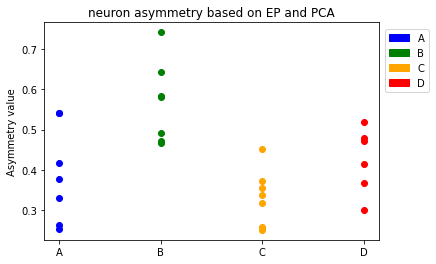

In [53]:
# for scatter plot of Y_value grouped by subtype on the x_axis
fig, ax = plt.subplots(1)
colors = {'A':'b','B':'g','C':'orange','D':'r'}
x_p = {'A':1,'B':2,'C':3,'D':4}
# y_vals = (results_df.surface_area/results_df.volume)
# y_vals = y_vals/y_vals.max()
y_vals = results_df.asymmetry
for i,neu in enumerate(y_vals):
    ax.scatter(x_p[results_df.subtype[i]],neu,c=colors[results_df.subtype[i]])
plt.title('neuron asymmetry based on EP and PCA')
x = np.array([1,2,3,4])
my_xticks = ['A','B','C','D']
plt.xticks(x, my_xticks)
plt.ylabel('Asymmetry value')

legend_patches = []
for subtype,color in colors.items():
    legend_patches.append(mpatches.Circle((0,0),10,color=color, label=subtype))
plt.legend(handles=legend_patches, bbox_to_anchor=(1.15, 0.97), 
            loc=1, borderaxespad=0., prop={'size': 10})
# plt.savefig(save_path+'adult_T4_Asymmetry.png', facecolor='white', transparent=False)

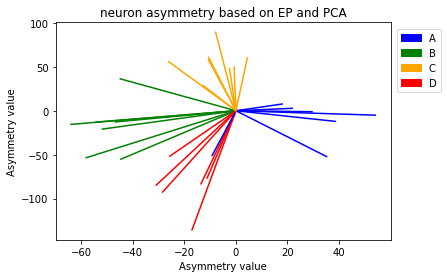

In [61]:
# To plot x,y value of one metric for individual neurons, colored by subtype
fig, ax = plt.subplots(1)
colors = {'A':'b','B':'g','C':'orange','D':'r'}
x_p = {'A':1,'B':2,'C':3,'D':4}
# y_vals = (results_df.surface_area/results_df.volume)
# y_vals = y_vals/y_vals.max()
y_vals = results_df.cen_EP_yx
for i,neu in enumerate(y_vals):
    ax.plot((0,neu[1]),(0,neu[0]),c=colors[results_df.subtype[i]])
plt.title('neuron asymmetry based on EP and PCA')
plt.ylabel('Asymmetry value')
plt.xlabel('Asymmetry value')

legend_patches = []
for subtype,color in colors.items():
    legend_patches.append(mpatches.Circle((0,0),10,color=color, label=subtype))
plt.legend(handles=legend_patches, bbox_to_anchor=(1.15, 0.97), 
            loc=1, borderaxespad=0., prop={'size': 10})

# plt.savefig(save_path+'adult_T4_Asymmetry.png', facecolor='white', transparent=False)